# Segmentation

## Importing dependencies

In [1]:
import numpy as np
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from skimage import morphology, io, color, exposure, img_as_float, transform
from matplotlib import pyplot as plt
import openslide as op
from PIL import Image
from util import IoU, Dice, masked, remove_small_regions, normalize
from scipy import misc

import time
import h5py


Using TensorFlow backend.


## Configuration

In [2]:
# Paths
filename = '/root/workspace/data/preExtraction/14_02/IFTA_14_02.svs'
maskname = '/root/workspace/data/preExtraction/14_02/IFTA_14_02.png'
h5f = h5py.File('/root/workspace/data/train/matrice_train.h5','r')

model_name = './model.099.hdf5'

# Do not touch
level=1
patchSize = 256
colorChannels = 3
#stride = patchSize//2
stride = 256

patchShape = (patchSize, patchSize,colorChannels) # Shape of the image (patch)
patchMaskShape = (patchSize, patchSize)   # Shape of the mask (patch)

## Image loading

### Loading base picture

In [3]:
im = op.OpenSlide(filename)
imload = np.asfarray(im.read_region((0,0), 1, im.level_dimensions[1]),dtype=np.float32)[:,:,0:colorChannels]/255



In [4]:
print(imload.mean())
print(imload.std())

0.82272
0.177734


In [5]:
#normalization
stats = h5f['stats'][:]
im_mean=stats[0]
im_std=stats[1]
h5f.close()

print(im_mean)
print(im_std)
print(imload.mean())
print(imload.std())

imload-=imload.mean()
imload/=imload.std()
#imload-=im_mean
#imload/=im_std

0.701738603022
0.2016647797
0.82272
0.177734


In [6]:
print(imload.mean())
print(imload.std())

-7.137e-05
1.0


### Loading mask

In [7]:
maskload = Image.open(maskname)
maskload = np.expand_dims(np.array(maskload.resize(im.level_dimensions[level]),dtype=np.float32),-1)

### Allocating final array

In [8]:
outputProba = np.zeros((im.level_dimensions[level][1],im.level_dimensions[level][0]),dtype=np.float32)
outputProbaTimes = np.zeros((im.level_dimensions[level][1],im.level_dimensions[level][0]),dtype=np.uint8)

In [9]:
#outputThreshold = np.zeros((im.level_dimensions[level][1],im.level_dimensions[level][0], colorChannels),dtype=np.uint8)

## Loading model

In [10]:
# Load model
UNet = load_model(model_name)

## Execution

### Initialization  

In [12]:
#test_gen = ImageDataGenerator(rescale=1.)

### Prediction

In [15]:
iterTest=0
for posX in range(0,im.level_dimensions[level][0]-256,stride):
    for posY in range(0,im.level_dimensions[level][1]-256,stride):
        iterTest+=1
print(iterTest)

3360


In [18]:
print((im.level_dimensions[level][1]-256)//stride+1)
print((im.level_dimensions[level][0]-256)//stride+1)
print(70*48)

48
70
3360


In [22]:
#sizeInter = ((im.level_dimensions[level][0]-256)//stride+1)*((im.level_dimensions[level][1]-256)//stride+1)
sizeInter = (im.level_dimensions[level][1]-256)//stride+1

interX = np.zeros((sizeInter,256,256,3),dtype=np.float32)
interY = np.zeros((sizeInter,256,256,1),dtype=np.float32)

In [24]:
t0 = time.clock()
currIter=0

# Prediction
for posX in range(0,im.level_dimensions[level][0]-256,stride):
    currIter=0
    for posY in range(0,im.level_dimensions[level][1]-256,stride):
    
        xx = np.expand_dims(imload[posY:posY+256,posX:posX+256,:],0)
        yy = np.expand_dims(maskload[posY:posY+256,posX:posX+256,:],0)

        interX[currIter,:,:,:]=xx
        interY[currIter,:,:,:]=yy

        currIter+=1
        
        
    pred = UNet.predict_generator(test_gen.flow(interX, interY, batch_size=currIter), steps=1, use_multiprocessing=True)#[..., 0].reshape(patchShape[:2])
    
    #part=outputProba[posY:posY+256,posX:posX+256]
    #part[:,:]+=pred[0:part.shape[0],0:part.shape[1]]
    #outputProbaTimes[posY:posY+256,posX:posX+256]+=1

t = time.clock()
print("Execution duration : ", t-t0)

Execution duration :  55.76511899999997


In [13]:
t0 = time.clock()


# Prediction
for posX in range(0,im.level_dimensions[level][0]-256,stride):
    for posY in range(0,im.level_dimensions[level][1]-256,stride):

        xx = np.expand_dims(imload[posY:posY+256,posX:posX+256,:],0)
        yy = maskload[posY:posY+256,posX:posX+256,:]
        xx = xx[:,:,:,0:1]
        pred = UNet.predict(xx)[..., 0].reshape(patchShape[:2])

        part=outputProba[posY:posY+256,posX:posX+256]
        part[:,:]+=pred[0:part.shape[0],0:part.shape[1]]
        outputProbaTimes[posY:posY+256,posX:posX+256]+=1

t = time.clock()
print("Execution duration : ", t-t0)

Execution duration :  117.734408


In [18]:
nononeonfozenf

import itertools
from multiprocessing import Pool, Lock
import os


#A function which will process a tuple of parameters
def do_job(params):
    posX = params[0]
    posY = params[1]
    print(posX , " : ", posY)
    xx = np.expand_dims(imload[posY:posY+256,posX:posX+256,:],0)
    print("X" , xx.max())
    print("X" , xx.min())
    yy = maskload[posY:posY+256,posX:posX+256,:]
    print("Y" , yy.min())
    print("Y" , yy.max())
    #print("start : ", posX , " : ", posY)
        
    #pred = UNet.predict22(xx)#[..., 0].reshape(patchShape[:2])
    #print("end : ", posX , " : ", posY)
    
    with lock:
        print("start : ", posX , " : ", posY)
        
        pred = UNet.predict(xx)[..., 0].reshape(patchShape[:2])
        print("end : ", posX , " : ", posY)
    
        #part=outputProba[posY:posY+256,posX:posX+256]
        #part[:,:]+=pred[0:part.shape[0],0:part.shape[1]]
        #outputProbaTimes[posY:posY+256,posX:posX+256]+=1

    return posX*posY

def init_child(lock_):
    global lock
    lock = lock_



def lauch_multi():
    #Generate values for each parameter
    a = range(2)
    b = range(2)
    #a = range(0,im.level_dimensions[level][0]-256,stride)
    #b = range(0,im.level_dimensions[level][1]-256,stride)

    #Generate a list of tuples where each tuple is a combination of parameters.
    #The list will contain all possible combinations of parameters.
    paramlist = list(itertools.product(a,b))
    
    lock = Lock()
    poolsize = os.cpu_count()
    
    #Generate processes equal to the number of cores
    pool = Pool(processes=poolsize, initializer=init_child, initargs=(lock,))

    #Distribute the parameter sets evenly across the cores
    res  = pool.map(do_job,paramlist)

In [19]:
t0 = time.clock()
lauch_multi()
t = time.clock()
print("Execution duration : ", t-t0)

1  :  1
X 1.0
X 0.717647
Y 0.0
1  :  0
Y 0.0
start :  1  :  1
X 1.0
X 1.0
X 0.717647
Y 0.0
Y 0.0
start :  1  :  0
0  :  0
0  :  1
X 1.0
X 0.717647
X 0.717647
Y 0.0
Y 0.0
start :  0  :  0
Y 0.0


AttributeError: 'Model' object has no attribute 'predict22'

Y 0.0
start :  0  :  1


### code that follows in progress 

In [14]:
outputProba/=outputProbaTimes

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [15]:
np.putmask(outputProba, outputProba != outputProba, 0)


In [16]:
print(outputProba.min())
print(outputProba.max())

0.0
1.0


In [17]:
outputProbaThresh = outputProba > 0.9
maskTresh = maskload > 0.5

In [18]:
outputProbaThresh = remove_small_regions(outputProbaThresh, 0.02 * np.prod(patchShape))

In [19]:
testDelAmore = np.dstack((outputProbaThresh.astype(np.int8), maskTresh.astype(np.int8), outputProbaThresh.astype(np.int8)))

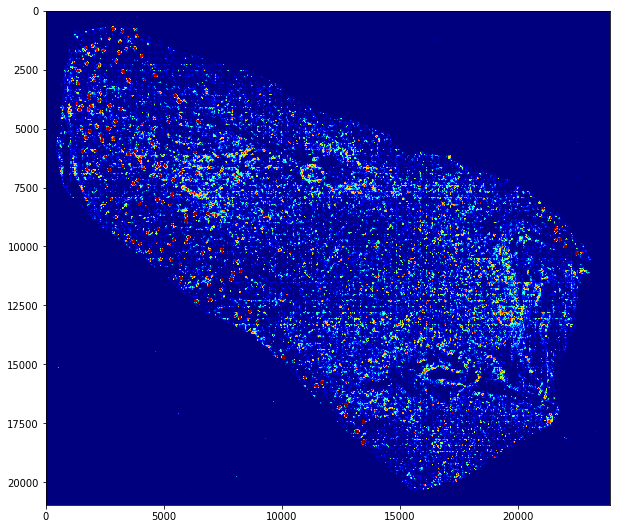

In [20]:
plt.figure(figsize = (20,20)) # create a 5 x 5 figure *
plt.subplot(211)
plt.imshow(outputProba,interpolation='none', cmap="jet")
plt.show()

#plt.close()

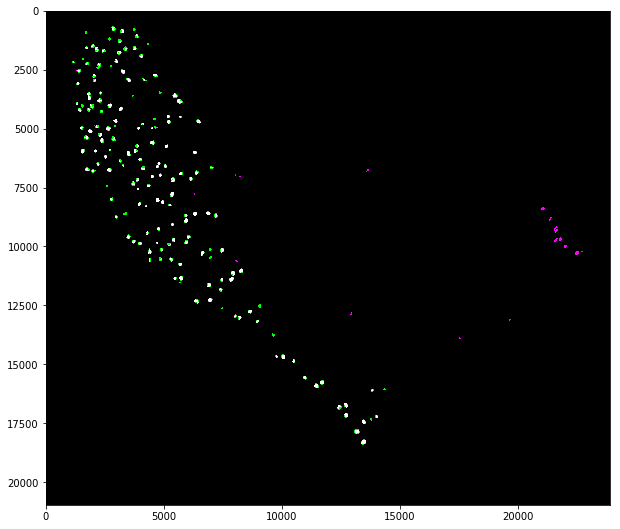

In [21]:
plt.figure(figsize = (20,20)) # create a 5 x 5 figure *
plt.subplot(211)
plt.imshow(testDelAmore,interpolation='none', cmap="jet")
plt.show()

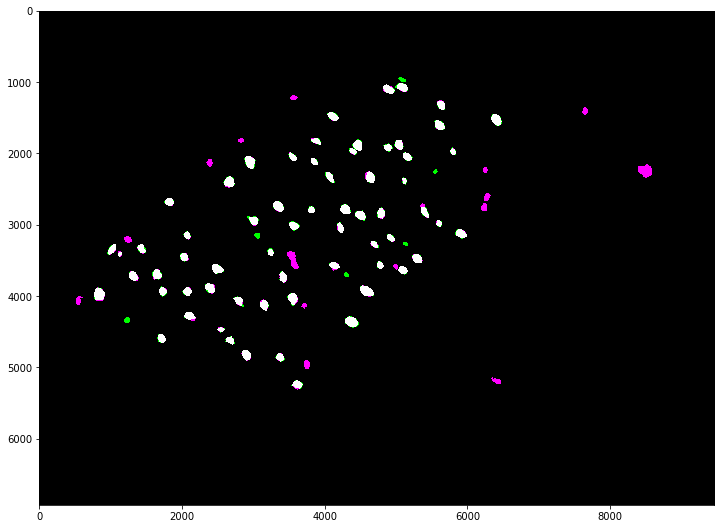

In [19]:
plt.figure(figsize = (20,20)) # create a 5 x 5 figure *
plt.subplot(211)
plt.imshow(testDelAmore,interpolation='none', cmap="jet")
plt.show()

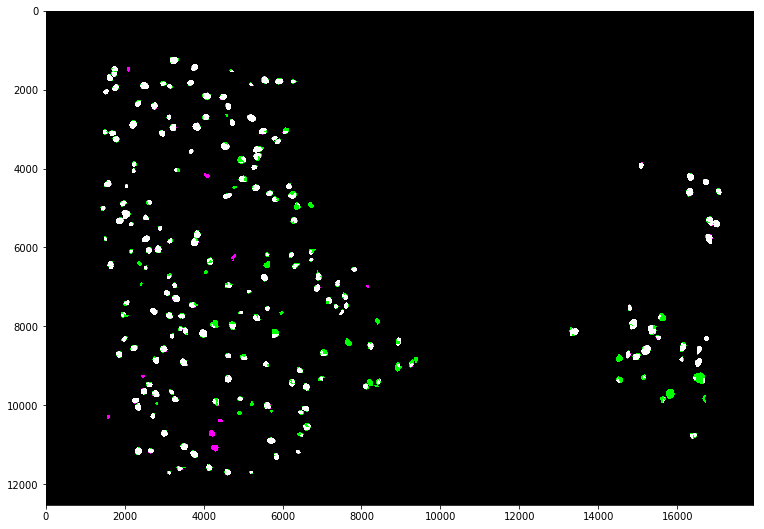

In [50]:
plt.figure(figsize = (20,20)) # create a 5 x 5 figure *
plt.subplot(211)
plt.imshow(testDelAmore,interpolation='none', cmap="jet")
plt.show()

In [35]:
misc.imsave("../data/prediction/prediction_12-02_64_10-11-13-200-100.png", testDelAmore)


MemoryError: 

In [36]:
maskImage = Image.fromarray(testDelAmore, 'RGB')
maskImage.save("../data/prediction/prediction_14-02_256_0.9_10-11-13-200-100.png")

In [39]:
testDelAmore.shape

(20953, 23903, 3)

In [43]:
maskImage.getcolors()

[(2414827, (1, 1, 1)),
 (1055501, (0, 1, 0)),
 (238459, (1, 0, 1)),
 (497130772, (0, 0, 0))]

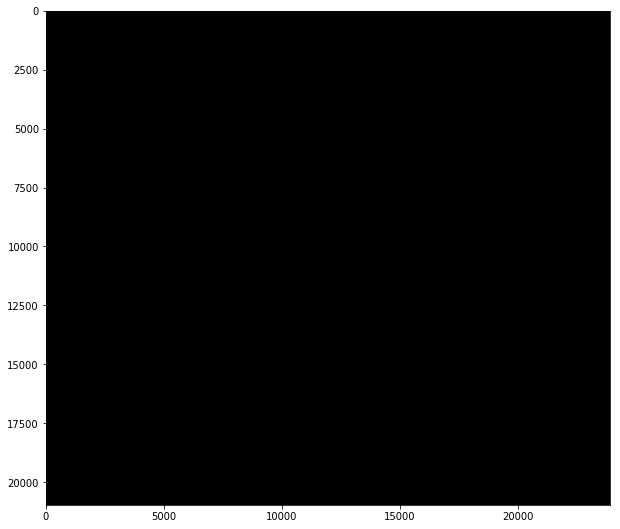

In [37]:
plt.figure(figsize = (20,20)) # create a 5 x 5 figure *
plt.subplot(211)
plt.imshow(maskImage,interpolation='none', cmap="jet")
plt.show()